In [1]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin, BaseEstimator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Masking
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Convolution1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
df = pd.read_csv("/content/sample_data/Racist_Sexist_Dataset.csv")

In [7]:
df.head()

,﻿id,tweet,class
0,5.720000e+17,So Drasko just said he was impressed the girls...,1
1,5.720000e+17,Drasko they didn&#39;t cook half a bird you id...,1
2,5.720000e+17,Hopefully someone cooks Drasko in the next ep ...,1
3,5.720000e+17,of course you were born in serbia...you&#39;re...,1
4,5.720000e+17,These girls are the equivalent of the irritati...,1


In [8]:
df.tail()

,﻿id,tweet,class
15943,5.760000e+17,credible reports that Iranian troops &amp; fig...,0
15944,5.760000e+17,RT BillSpindle: It&#39;s all about power at th...,0
15945,5.770000e+17,DEAR STATE DEPARTMENT: WHERE IS HILLARY CLINTO...,0
15946,5.610000e+17,@panelrific: Let&#39;s go üêßüêßüêßüêßüêß...,0
15947,5.690000e+17,üòÇ http://t.co/VQzuAXqNzd,0


In [9]:
df.describe()

,﻿id,class
count,1.594800e+04,15948.000000
mean,5.569026e+17,0.508904
std,3.775839e+16,0.798888
min,3.190000e+17,0.000000
25%,5.630000e+17,0.000000
50%,5.700000e+17,0.000000
75%,5.750000e+17,1.000000
max,6.850000e+17,2.000000


In [10]:
df.columns

Index(['﻿id', 'tweet', 'class'], dtype='object')

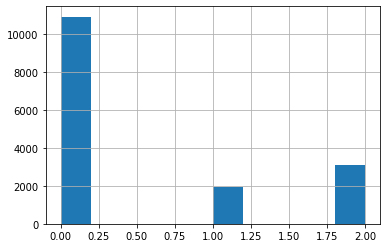

In [11]:
df['class'].hist()

In [12]:
tweets=df.tweet

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Feature Generation

In [14]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


In [17]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [18]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [19]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

In [21]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [22]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [23]:
feats = get_feature_array(tweets)

In [24]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [25]:
M.shape

(15948, 3777)

In [26]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

## Running the Model

In [27]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [28]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(11961, 3777)
(3987, 3777)
(3987,)
(11961,)


In [31]:
X_train.fillna(method="pad", inplace=True)
X_test.fillna(method="pad", inplace=True)
y_train.fillna(method="pad", inplace=True)
y_test.fillna(method="pad", inplace=True)

In [32]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))

In [33]:
 def create_RNN_Data(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, seq_len = 5):
    y_train, y_test = np.array(y_train_scaled)[seq_len-1:], np.array(y_test_scaled)[seq_len-1:]
    X_train = np.zeros((X_train_scaled.shape[0]+1-seq_len, seq_len, X_train_scaled.shape[1]))
    X_test = np.zeros((X_test_scaled.shape[0]+1-seq_len, seq_len, X_test_scaled.shape[1]))
    for i in range(seq_len):
        X_train[:, i, :] = np.array(X_train_scaled)[i:X_train_scaled.shape[0]+i+1-seq_len, :]
        X_test[:, i, :] = np.array(X_test_scaled)[i:X_test_scaled.shape[0]+i+1-seq_len, :]
    return X_train, X_test, y_train, y_test

In [34]:
X_train, X_test, y_train, y_test = create_RNN_Data(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(11957, 5, 3777)
(3983, 5, 3777)
(3983, 1)
(11957, 1)


In [36]:
simple_RNN = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[5, 3777])
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [37]:
simple_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3779      
                                                                 
Total params: 3,779
Trainable params: 3,779
Non-trainable params: 0
_________________________________________________________________


In [38]:
simple_RNN.compile(loss="mse", optimizer=optimizer)
history_simple_rnn = simple_RNN.fit(X_train, y_train, epochs=50,
                    validation_data=(X_test, y_test))

Epoch 1/50
374/374 [==============================] - 4s 8ms/step - loss: 0.1633 - val_loss: 0.1423
Epoch 2/50
374/374 [==============================] - 2s 6ms/step - loss: 0.1302 - val_loss: 0.1324
Epoch 3/50
374/374 [==============================] - 2s 6ms/step - loss: 0.1159 - val_loss: 0.1260
Epoch 4/50
374/374 [==============================] - 2s 6ms/step - loss: 0.1070 - val_loss: 0.1218
Epoch 5/50
374/374 [==============================] - 2s 6ms/step - loss: 0.1005 - val_loss: 0.1202
Epoch 6/50
374/374 [==============================] - 2s 6ms/step - loss: 0.0962 - val_loss: 0.1220
Epoch 7/50
374/374 [==============================] - 2s 6ms/step - loss: 0.0932 - val_loss: 0.1229
Epoch 8/50
374/374 [==============================] - 2s 6ms/step - loss: 0.0909 - val_loss: 0.1232
Epoch 9/50
374/374 [==============================] - 2s 7ms/step - loss: 0.0893 - val_loss: 0.1247
Epoch 10/50
374/374 [==============================] - 2s 6ms/step - loss: 0.0881 - val_loss: 0.1268

In [39]:
# accuracy: (tp + tn) / (p + n)
scores = simple_RNN.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores*100))

Accuracy: 15.88%


In [40]:
# Error Metrics
from sklearn.metrics import mean_squared_error
error_Training_simple_RNN = mean_squared_error(y_train, simple_RNN.predict(X_train))
simple_RNN_predicted = simple_RNN.predict(X_test)
error_Test_simple_RNN = mean_squared_error(y_test,simple_RNN_predicted)

In [41]:
rmse = metrics.mean_squared_error(y_test,simple_RNN_predicted)
print ('Root Mean Squared Error:',rmse)
print('Accuracy rs : {}'.format(r2_score(y_test, simple_RNN_predicted)))

Root Mean Squared Error: 0.15876463082940342
Accuracy rs : -0.026939393062739958


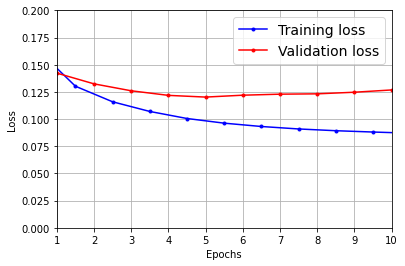

In [42]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0, 0.20])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history_simple_rnn.history["loss"], history_simple_rnn.history["val_loss"])
plt.show()

In [43]:
Deep_RNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[5,3777]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [44]:
Deep_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 5, 20)             75960     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 5, 20)             820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 76,802
Trainable params: 76,802
Non-trainable params: 0
_________________________________________________________________


In [45]:
Deep_RNN.compile(loss="mse", optimizer="adam")
history_Deep_RNN = Deep_RNN.fit(X_train, y_train, epochs=50,
                    validation_data=(X_test, y_test)) 

Epoch 1/50
374/374 [==============================] - 7s 14ms/step - loss: 0.1520 - val_loss: 0.1235
Epoch 2/50
374/374 [==============================] - 5s 14ms/step - loss: 0.0932 - val_loss: 0.1287
Epoch 3/50
374/374 [==============================] - 5s 13ms/step - loss: 0.0650 - val_loss: 0.1510
Epoch 4/50
374/374 [==============================] - 5s 13ms/step - loss: 0.0432 - val_loss: 0.1532
Epoch 5/50
374/374 [==============================] - 5s 13ms/step - loss: 0.0301 - val_loss: 0.1676
Epoch 6/50
374/374 [==============================] - 5s 14ms/step - loss: 0.0216 - val_loss: 0.1692
Epoch 7/50
374/374 [==============================] - 7s 19ms/step - loss: 0.0169 - val_loss: 0.1772
Epoch 8/50
374/374 [==============================] - 5s 14ms/step - loss: 0.0143 - val_loss: 0.1791
Epoch 9/50
374/374 [==============================] - 5s 14ms/step - loss: 0.0133 - val_loss: 0.1772
Epoch 10/50
374/374 [==============================] - 5s 14ms/step - loss: 0.0113 - val_lo

In [46]:
Deep_RNN.evaluate(X_test, y_test)

125/125 [==============================] - 1s 6ms/step - loss: 0.1750


0.17495635151863098

In [47]:
scores = Deep_RNN.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores*100))

Accuracy: 17.50%


In [48]:
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [49]:
# Error Metrics
error_Training_Deep_RNN = mean_squared_error(y_train, Deep_RNN.predict(X_train))
Deep_RNN_predicted = Deep_RNN.predict(X_test)
error_Test_Deep_RNN = mean_squared_error(y_test,Deep_RNN_predicted)

In [50]:
rmse = metrics.mean_squared_error(y_test,Deep_RNN_predicted)
print ('Root Mean Squared Error:',rmse)
print('Accuracy rs : {}'.format(r2_score(y_test, Deep_RNN_predicted)))

Root Mean Squared Error: 0.17495636116604588
Accuracy rs : -0.13167257977870483


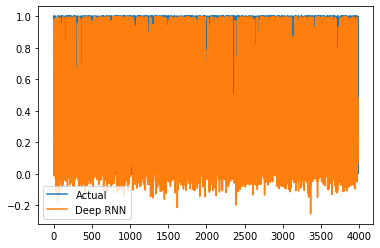

In [51]:
plt.plot(y_test_scaled, label = "Actual")
plt.plot(Deep_RNN_predicted, label = "Deep RNN")
plt.legend()
plt.show()

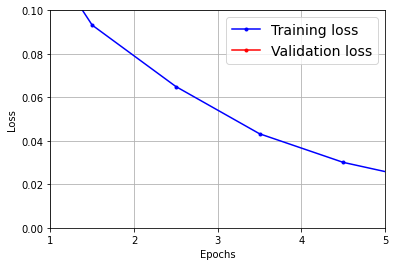

In [52]:
import matplotlib as mpl
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 5, 0, 0.10])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history_Deep_RNN.history["loss"], history_Deep_RNN.history["val_loss"])
plt.show()

In [53]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [55]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))

In [56]:
def create_CNN_Data(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, seq_len = 5):
    y_train_CNN, y_test_CNN = np.array(y_train_scaled)[seq_len-1:], np.array(y_test_scaled)[seq_len-1:]
    X_train_CNN = np.zeros((X_train_scaled.shape[0]+1-seq_len, seq_len, X_train_scaled.shape[1]))
    X_test_CNN = np.zeros((X_test_scaled.shape[0]+1-seq_len, seq_len, X_test_scaled.shape[1]))
    for i in range(seq_len):
        X_train_CNN[:, i, :] = np.array(X_train_scaled)[i:X_train_scaled.shape[0]+i+1-seq_len, :]
        X_test_CNN[:, i, :] = np.array(X_test_scaled)[i:X_test_scaled.shape[0]+i+1-seq_len, :]
    return X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN

In [57]:
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = create_CNN_Data(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

In [58]:
# LSTM and CNN for sequence classification in the dataset
# create the model
embedding_vecor_length = 32
CNN = Sequential()
CNN.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(5,3777)))
CNN.add(MaxPooling1D(pool_size=2))
CNN.add(LSTM(100))
CNN.add(Dense(1, activation='sigmoid'))

In [59]:
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(CNN.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             362624    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 415,925
Trainable params: 415,925
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
CNN.fit(X_train_CNN, y_train_CNN, epochs=50, batch_size=64)

Epoch 1/50
187/187 [==============================] - 14s 57ms/step - loss: 0.5750 - accuracy: 0.6797
Epoch 2/50
187/187 [==============================] - 6s 32ms/step - loss: 0.5307 - accuracy: 0.6850
Epoch 3/50
187/187 [==============================] - 6s 33ms/step - loss: 0.4242 - accuracy: 0.7395
Epoch 4/50
187/187 [==============================] - 6s 32ms/step - loss: 0.2889 - accuracy: 0.8141
Epoch 5/50
187/187 [==============================] - 6s 32ms/step - loss: 0.1969 - accuracy: 0.8551
Epoch 6/50
187/187 [==============================] - 6s 32ms/step - loss: 0.1597 - accuracy: 0.8708
Epoch 7/50
187/187 [==============================] - 6s 32ms/step - loss: 0.1519 - accuracy: 0.8754
Epoch 8/50
187/187 [==============================] - 6s 32ms/step - loss: 0.1316 - accuracy: 0.8777
Epoch 9/50
187/187 [==============================] - 6s 32ms/step - loss: 0.1251 - accuracy: 0.8784
Epoch 10/50
187/187 [==============================] - 6s 32ms/step - loss: 0.1236 - accur